# Customising Banana for Your Analysis

Now you understand how to write Arcana Analysis classes and have an idea of what is already implemented in Banana you can customise the analysis implemented in it to your needs.

**Note:** Before doing any customisations, have a good look through the parameters of the class to see whether there is already a switch to do what you want.

There are a couple of ways you might want to extend an existing class:

* Adding/overwriting a new parameter or parameter option
* Add new derivatives and pipeline constructors
* Overwrite/modify an existing pipeline constructor

For this notebook we will use the `BasicBrainAnalysis` class again instead of a "real" class from Banana as the analysis in those classes typically takes too long for the time we have available for this workshop. However, the concepts are the same.

## Adding/Overwriting Parameters

Adding a new parameter to a class is pretty straightforward, simply extend the class and put your new parameter in `add_param_specs`.

In [1]:
from nipype import config
config.enable_debug_mode()  # This is necessary due to a bug in one of the interfaces
from arcana import Analysis, AnalysisMetaClass, ParamSpec, SwitchSpec
from example.analysis import BasicBrainAnalysis


class MyExtendendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    add_param_specs = [
        ParamSpec('bet_frac', 0.1, desc="The fractional intensity threshold for BET")
    ]
    
print(MyExtendendedBasicBrainAnalysis.static_menu())

191115-15:10:31,353 nipype.interface DEBUG:
	 args_matlab

__main__.MyExtendendedBasicBrainAnalysis Menu 
----------------------------------------------

Inputs:
    magnitude : nifti_gz
        A magnitude image (e.g. T1w, T2w, etc..)

Outputs:
    brain : nifti_gz
        Skull-stripped magnitude image
    smooth : nifti_gz
        Smoothed magnitude image
    smooth_masked : nifti_gz
        Smoothed and masked magnitude image

Parameters:
    bet_frac : float (0.1)
        The fractional intensity threshold for BET
    smoothing_fwhm : float (4.0)
        The full-width-half-maxium radius of the smoothing kernel


Alternatively if you just want to change the default value for an existing parameter you can override it

In [2]:
from arcana import Analysis, AnalysisMetaClass, ParamSpec, SwitchSpec
from example.analysis import BasicBrainAnalysis


class MyExtendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    add_param_specs = [
        ParamSpec('smoothing_fwhm', 2)
    ]
    
print(MyExtendedBasicBrainAnalysis.static_menu())


__main__.MyExtendedBasicBrainAnalysis Menu 
-------------------------------------------

Inputs:
    magnitude : nifti_gz
        A magnitude image (e.g. T1w, T2w, etc..)

Outputs:
    brain : nifti_gz
        Skull-stripped magnitude image
    smooth : nifti_gz
        Smoothed magnitude image
    smooth_masked : nifti_gz
        Smoothed and masked magnitude image

Parameters:
    smoothing_fwhm : int (2)
        


Notice how we have lost the description of the parameter because we didn't provide it in the overwritten version. Instead of having to type the same thing again we can generate a new version of the original `ParamSpec` with a new default value by accessing the original from BasicBrainAnalysis and using the `with_new_default` method

In [3]:
class MyExtendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    add_param_specs = [
        BasicBrainAnalysis.param_spec('smoothing_fwhm').with_new_default(2.0)
    ]
    
print(MyExtendedBasicBrainAnalysis.static_menu())


__main__.MyExtendedBasicBrainAnalysis Menu 
-------------------------------------------

Inputs:
    magnitude : nifti_gz
        A magnitude image (e.g. T1w, T2w, etc..)

Outputs:
    brain : nifti_gz
        Skull-stripped magnitude image
    smooth : nifti_gz
        Smoothed magnitude image
    smooth_masked : nifti_gz
        Smoothed and masked magnitude image

Parameters:
    smoothing_fwhm : float (2.0)
        The full-width-half-maxium radius of the smoothing kernel


## Adding New Data-Specs

Adding new data-specs is the same as adding new parameters just append them to the `add_data_specs` list of your extended class

In [5]:
from arcana import OutputFilesetSpec
from banana.file_format import nifti_gz_format


class MyExtendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    add_data_specs = [
        OutputFilesetSpec('skull_mask', nifti_gz_format,
                          'brain_extraction_pipeline',
                          desc="Skull mask extracted from magnitude image"),
    ]
    
print(MyExtendedBasicBrainAnalysis.static_menu())


__main__.MyExtendedBasicBrainAnalysis Menu 
-------------------------------------------

Inputs:
    magnitude : nifti_gz
        A magnitude image (e.g. T1w, T2w, etc..)

Outputs:
    brain : nifti_gz
        Skull-stripped magnitude image
    skull_mask : nifti_gz
        Skull mask extracted from magnitude image
    smooth : nifti_gz
        Smoothed magnitude image
    smooth_masked : nifti_gz
        Smoothed and masked magnitude image

Parameters:
    smoothing_fwhm : float (4.0)
        The full-width-half-maxium radius of the smoothing kernel


## Modifying and Overwriting Constructor Methods

Of course if you add new parameters and/or data specs you will need to add or modify the pipelines that use/generate them. Adding a new method is straightforward, simply define it in your extended class. Likewise overriding a method you just need to name your pipeline constructor method as it is in the base class. However, in most cases you will just want to modify the pipeline instead, in which case we use the built-in `super`.

In [6]:
from nipype.interfaces import fsl
fsl.BET.help()

Wraps the executable command ``bet``.

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (an existing file name)
                input file to skull strip
                argument: ``%s``, position: 0

        [Optional]
        out_file: (a file name)
                name of output skull stripped image
                argument: ``%s``, position: 1
        outline: (a boolean)
                create surface outline image
                argument: ``-o``
        mask: (a boolean)
                create binary mask image
                argument: ``-m``
        skull: 

In [12]:
from arcana import OutputFilesetSpec
from banana.file_format import nifti_gz_format


class MyExtendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    add_data_specs = [
        OutputFilesetSpec('skull_mask', nifti_gz_format,
                          'brain_extraction_pipeline',
                          desc="Skull mask extracted from magnitude image"),
    ]
    
    def brain_extraction_pipeline(self, **name_maps):
        pipeline = super().brain_extraction_pipeline(**name_maps)
        
        bet = pipeline.node('bet')

        # Set the input of the BET node so that it outputs a Skull mask
        bet.inputs.surfaces = True
        
        pipeline.connect_output('skull_mask', bet, 'skull_mask_file', nifti_gz_format)
        
        return pipeline

In [17]:
from arcana import Dataset, FilesetFilter, SingleProc

def run_analysis():
    my_analysis = MyExtendedBasicBrainAnalysis(
        'my_extended_analysis',  # The name needs to be the same as the previous version
        dataset=Dataset('output/sample-datasets/depth1', depth=1),
        processor=SingleProc('work'),
        inputs=[
            FilesetFilter('magnitude', '.*T1w$', is_regex=True)])

    my_analysis.derive('skull_mask')

/usr/local/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/usr/local/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


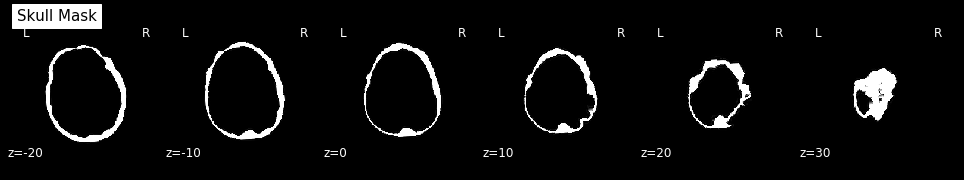

In [14]:
import os.path as op
from nilearn import plotting, image
def plot_slices(path, title):
    plotting.plot_anat(image.load_img(op.join('output/sample-datasets/depth1', path)),
                       title=title, display_mode='z', dim=-1,
                       cut_coords=[-20, -10, 0, 10, 20, 30])

plot_slices('sub1/my_extended_analysis/skull_mask.nii.gz', 'Skull Mask')

## Exercise 1

Modify the `smooth_mask_pipeline` so that it uses the 'sigma' parameter instead of the 'fwhm' parameter to define the smoothing kernel and then plot the results of `smooth_masked`

In [8]:
## Write your solution here

__prov__             fields.json          smooth.mif
brain.nii.gz         fields.json.lock     smooth_masked.nii.gz
brain_mask.nii.gz    skull_mask.nii.gz


In [13]:
from arcana import OutputFilesetSpec
from banana.file_format import nifti_gz_format
from nipype import undefined


class MyExtendedBasicBrainAnalysis(BasicBrainAnalysis, metaclass=AnalysisMetaClass):
    
    def smooth_mask_pipeline(self, **name_maps):
        pipeline = super().smooth_mask_pipeline(**name_maps)
        
        smooth = pipeline.node('smooth')

        # Set the input of the BET node so that it outputs a Skull mask
        smooth.inputs.fwhm = undefined
        smooth.inputs.sigma = 2.0
        
        return pipeline

my_analysis
my_extended_analysis
sub-01_ses-test_T1w.nii.gz
sub-01_ses-test_T1w_bet.nii.gz
sub-01_ses-test_dwi.nii.gz
sub-01_ses-test_task-covertverbgeneration_bold.nii.gz
sub-01_ses-test_task-fingerfootlips_bold.nii.gz
sub-01_ses-test_task-linebisection_bold.nii.gz
sub-01_ses-test_task-overtverbgeneration_bold.nii.gz
sub-01_ses-test_task-overtwordrepetition_bold.nii.gz


In [18]:
run_analysis()

NameError: name 'MyExtendedBasicBrainAnalysis' is not defined